In [25]:
from neo4j import GraphDatabase

from matplotlib import pylab
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

import plotly.graph_objects as go

import networkx as nx
import numpy as np

from dotenv import load_dotenv

import json, random, statistics, os, collections, pylab

load_dotenv("../.env")

True

In [3]:
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_NAME = os.getenv("NEO4J_NAME")
NEO4J_PASS = os.getenv("NEO4J_PASS")

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_NAME, NEO4J_PASS))

In [4]:
# get graph
with driver.session() as session:
  res = session.run("MATCH (n)-[r:RETWEETED]-(m) RETURN n, r, m")
  g = nx.Graph()

  nodes = list(res.graph()._nodes.values())
  for node in nodes:
    node_kind = list(node._labels)[0] # converting frozenset to list, then taking the only value (tweet/author)
    g.add_node(node.id, labels=node._labels, properties=node._properties, kind = node_kind)

  rels = list(res.graph()._relationships.values())
  for rel in rels:
    g.add_edge(rel.start_node.id, rel.end_node.id, key=rel.id, type=rel.type, properties=rel._properties)

/tmp/ipykernel_22118/1301313705.py:9: DeprecationWarning: `id` is deprecated, use `element_id` instead
  g.add_node(node.id, labels=node._labels, properties=node._properties, kind = node_kind)
/tmp/ipykernel_22118/1301313705.py:13: DeprecationWarning: `id` is deprecated, use `element_id` instead
  g.add_edge(rel.start_node.id, rel.end_node.id, key=rel.id, type=rel.type, properties=rel._properties)


In [5]:
# removing self loops
g.remove_edges_from(nx.selfloop_edges(g))

# prune disconnected nodes
relevant_graph = g.subgraph(max(nx.connected_components(g), key=len))

print(relevant_graph)

Graph with 14439 nodes and 16531 edges


In [6]:
pos = nx.spring_layout(relevant_graph)

In [7]:
def hex_to_RGB(hex_str):
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]

    return rgb_colors

calculated centrality metrics for 14439 nodes

percentiles: [2.9097707192604616e-05, 0.00017327081241489943, 0.00031744391763719425, 0.0004616170228594891, 0.0006057901280817838, 0.0007499632333040787, 0.0008941363385263736, 0.0010383094437486683, 0.0011824825489709632, 0.001326655654193258, 0.0014708287594155528, 0.0016150018646378477, 0.0017591749698601426, 0.0019033480750824372, 0.0020475211803047317, 0.0021916942855270266, 0.0023358673907493215, 0.0024800404959716164, 0.0026242136011939113, 0.0027683867064162058, 0.0029125598116385007, 0.0030567329168607956, 0.0032009060220830905, 0.0033450791273053854, 0.0034892522325276802, 0.0036334253377499747, 0.0037775984429722696, 0.0039217715481945645, 0.004065944653416859, 0.004210117758639154, 0.004354290863861449, 0.004498463969083744, 0.0046426370743060386, 0.004786810179528333, 0.004930983284750628, 0.005075156389972923, 0.005219329495195218, 0.005363502600417513, 0.005507675705639807, 0.005651848810862102, 0.005796021916084397, 0.0059

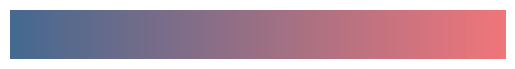

In [70]:
centrality_data = nx.algorithms.pagerank(relevant_graph)
print(f"calculated centrality metrics for {len(centrality_data)} nodes\n")

centrality_percentiles = np.histogram(list(centrality_data.values()), 100)[-1]
print(f"percentiles: {list(centrality_percentiles)}\n")

centrality_palette = get_color_gradient("#456990", "#EF767A", len(centrality_percentiles))
cmap = mcolors.LinearSegmentedColormap.from_list("palette", centrality_palette)

mat = np.indices((10, len(centrality_percentiles)))[1]
print("colors:")
plt.imshow(mat, cmap=cmap)
plt.axis("off")
plt.show()

In [26]:
node_groups = {}
centrality_values = sorted(list(centrality_percentiles))

for percentile in centrality_values:
    node_groups[str(percentile)] = { "nodes": [] }

for node, centrality in centrality_data.items():
    for i, value in enumerate(centrality_values):
        if centrality > value: 
            continue
        else:
            group = centrality_values[i-1] if i > 0 else centrality_values[i]
            group = str(group)
        break
    
    node_groups[group]["nodes"].append(node)


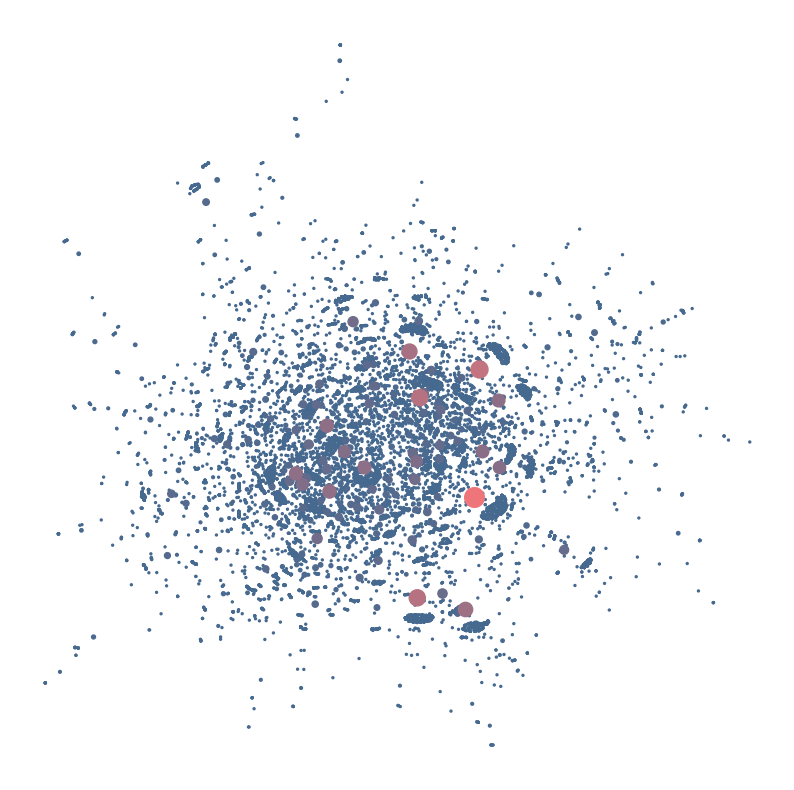

In [74]:
group_index = 1
for _, group in node_groups.items():
    subgraph = relevant_graph.subgraph(group["nodes"])
    group_color = [group_index/len(centrality_percentiles)] * len(group["nodes"])

    fig = plt.figure(1, figsize=(10, 10))
    plt.axis("off")
    collection = nx.draw_networkx_nodes(subgraph, pos, node_size=group_index*2, cmap=cmap, node_color=group_color, vmin=0, vmax=1, alpha=1)
    
    group_index += 1
